In [1]:
import h5py
import re
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.colors
import itertools
%matplotlib inline
import copy

/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# This notebook analyzes the R(E) error traces
It loads in the dictionaries in the "rerr_traces.h5" file, and then calculates the mean and credible intervals for the E0 and J0 parameters as a function of the FWHM error on the response amplitude and energy shift

In [2]:
def key2val(key):
    """
    This function reads in the resonse error keys and 
    returns the FWHM percentiles. 
    """
    return tuple(map(int, re.findall(r'\d+', key)))

In [3]:
def printKeys(hf):
    print('Data run,    trace keys')
    for keys in hf.keys():
        print(keys, list(hf[keys].keys()))

Open the h5 file and do statistics on it.

In [4]:
file = 'rerr_traces.h5'

with h5py.File(file, 'r') as hf:
    #printKeys(hf)
    fKeys = list(hf.keys())
    
    runKeys = list(filter(lambda x: x != 'GLOBAL', hf.keys())) # Ignore global params.
    statDict = {'FWHM_R':np.zeros_like(runKeys, dtype=int), 
                'FWHM_E':np.zeros_like(runKeys, dtype=int),
               'E0_mu':np.zeros_like(runKeys, dtype=float),
                'J0_mu':np.zeros_like(runKeys, dtype=float),
                'E0_ci':np.zeros((len(runKeys), 2), dtype=float),
                'J0_ci':np.zeros((len(runKeys), 2), dtype=float)
               }
    #print(list(hf['GLOBAL'].keys()))
    #print(hf['GLOBAL']['TRUE_E0'][0])
    #statDict['TRUE_E0'] = hf['GLOBAL']['TRUE_E0']
    for i, errSet in enumerate(runKeys): 
        statDict['FWHM_R'][i], statDict['FWHM_E'][i] = key2val(errSet)
        statDict['E0_mu'][i] = np.mean(hf[errSet]['E0'])
        statDict['J0_mu'][i] = np.mean(hf[errSet]['J0'])
        statDict['E0_ci'][i, :] = np.percentile(hf[errSet]['E0'], (2.5, 97.5))
        statDict['J0_ci'][i, :] = np.percentile(hf[errSet]['J0'], (2.5, 97.5))
    statDict['TRUE_E0'] = hf['GLOBAL']['TRUE_E0'].value
    statDict['TRUE_J0'] = hf['GLOBAL']['TRUE_J0'].value

### Visualize the mean $E_0$ and $J_0$ values along the diagonal errors 
(The same FWHM values for both the amplitude and energy R(E) uncertainty)

In [5]:
# Get index array of diagonal elements.
diagInd = np.where(statDict['FWHM_R'] == statDict['FWHM_E'])[0] 
yerr_E0 = np.abs(statDict['E0_ci'][diagInd]-
                 np.repeat(statDict['E0_mu'][diagInd, np.newaxis], 2, axis=1)).T
yerr_J0 = np.abs(statDict['J0_ci'][diagInd]-
                 np.repeat(statDict['J0_mu'][diagInd, np.newaxis], 2, axis=1)).T

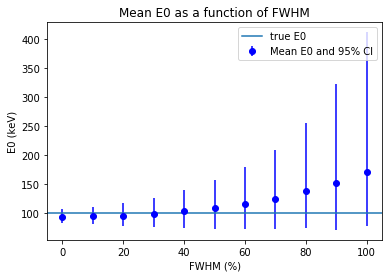

In [6]:
plt.errorbar(statDict['FWHM_R'][diagInd], statDict['E0_mu'][diagInd], 
             yerr=yerr_E0, fmt='bo', label='Mean E0 and 95% CI');
plt.axhline(statDict['TRUE_E0'], label='true E0');
plt.title('Mean E0 as a function of FWHM'); plt.xlabel('FWHM (%)'); 
plt.ylabel('E0 (keV)'); plt.legend();

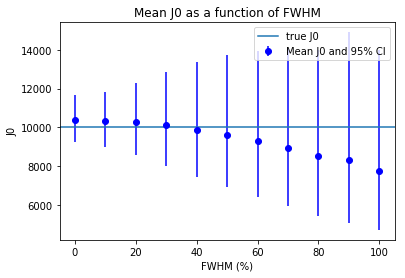

In [7]:
plt.errorbar(statDict['FWHM_R'][diagInd], statDict['J0_mu'][diagInd], 
             yerr=yerr_J0, fmt='bo', label='Mean J0 and 95% CI');
plt.axhline(statDict['TRUE_J0'], label='true J0');
plt.title('Mean J0 as a function of FWHM'); plt.xlabel('FWHM (%)'); 
plt.ylabel('J0'); plt.legend();

### Now visualize the relative error of the mean values of the traces using a scatter plot in the entire FWHM uncertainty space

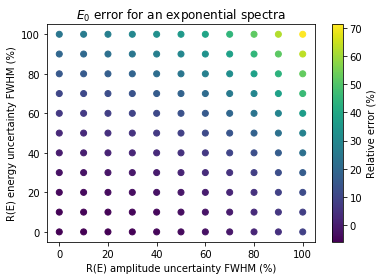

In [8]:
p = plt.scatter(statDict['FWHM_R'], statDict['FWHM_E'], 
                c=100*(statDict['E0_mu']-statDict['TRUE_E0'])/statDict['TRUE_E0'])
plt.colorbar(p, label='Relative error (%)'); 
plt.xlabel('R(E) amplitude uncertainty FWHM (%)');
plt.ylabel('R(E) energy uncertainty FWHM (%)');
plt.title(r'$E_0$ error for an exponential spectra');

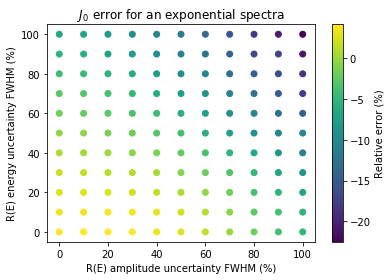

In [9]:
p = plt.scatter(statDict['FWHM_R'], statDict['FWHM_E'], 
                c=100*(statDict['J0_mu']-statDict['TRUE_J0'])/statDict['TRUE_J0'])
plt.colorbar(p, label='Relative error (%)'); 
plt.xlabel('R(E) amplitude uncertainty FWHM (%)');
plt.ylabel('R(E) energy uncertainty FWHM (%)');
plt.title(r'$J_0$ error for an exponential spectra');

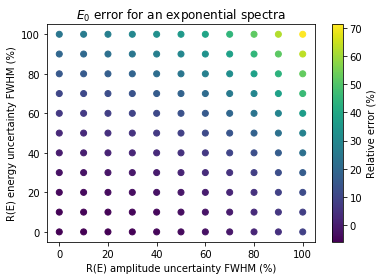

In [10]:
p = plt.scatter(statDict['FWHM_R'], statDict['FWHM_E'], 
                c=100*(statDict['E0_mu']-statDict['TRUE_E0'])/statDict['TRUE_E0'])
plt.colorbar(p, label='Relative error (%)'); 
plt.xlabel('R(E) amplitude uncertainty FWHM (%)');
plt.ylabel('R(E) energy uncertainty FWHM (%)');
plt.title(r'$E_0$ error for an exponential spectra');

In [11]:
RR, EE = np.meshgrid(sorted(list(set(statDict['FWHM_R'])) + [110]), 
                     sorted(list(set(statDict['FWHM_E']))) + [110])

In [12]:
C_E = np.nan*np.ones_like(RR)
C_J = np.nan*np.ones_like(RR)

for i, key in enumerate(runKeys):
    Rn, En = key2val(key)
    idx = np.where((Rn == RR) & (En == EE))
    C_E[idx[0][0], idx[1][0]] = 100*(statDict['E0_mu'][i]-
                                     statDict['TRUE_E0'])/statDict['TRUE_E0']
    C_J[idx[0][0], idx[1][0]] = 100*(statDict['J0_mu'][i]-
                                     statDict['TRUE_J0'])/statDict['TRUE_J0']


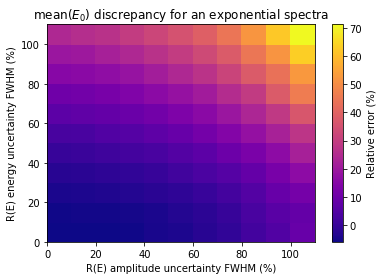

In [13]:
p = plt.pcolormesh(RR, EE, C_E, vmin=np.nanmin(C_E), vmax=np.nanmax(C_E), cmap='plasma');
plt.colorbar(p, label='Relative error (%)'); 
plt.xlabel('R(E) amplitude uncertainty FWHM (%)');
plt.ylabel('R(E) energy uncertainty FWHM (%)');
plt.title(r'mean($E_0$) discrepancy for an exponential spectra');

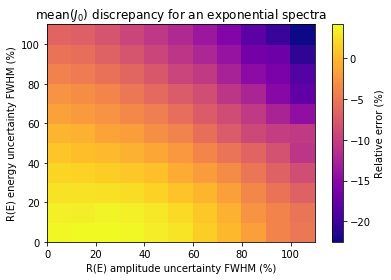

In [14]:
p = plt.pcolormesh(RR, EE, C_J, vmin=np.nanmin(C_J), vmax=np.nanmax(C_J), cmap='plasma');
plt.colorbar(p, label='Relative error (%)'); 
plt.xlabel('R(E) amplitude uncertainty FWHM (%)');
plt.ylabel('R(E) energy uncertainty FWHM (%)');
plt.title(r'mean($J_0$) discrepancy for an exponential spectra');